# Introduction to LangGraph

In this tutorial, we will build a support chatbot in LangGraph that can:
- Answer common questions by searching the Web.
- Maintain conversation state across calls.
- Route complex queries to a human for review.
- Use custom state to control its behavior.
- Rewind and explore alternative conversation paths.

We will:
- start with a basic chatbot,
- progressively add more sophisticated capabilities

This will allow us to introduce key LangGraph concepts along the way.

# Setup

In [5]:
import os

from dotenv import load_dotenv
from rich import print as rprint

In [7]:
_ = load_dotenv()
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

# 1. Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph.

This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

- Start by instanciating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a *"state machine"*.
- We'll add:
    - ` nodes` to represent:
        - the llm,
        - functions our chatbot can call;
    - `edges` to specify how the bot should transition between these `nodes`


In [10]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

> - **STACK OVERFLOW**: [**How to use python `typing.Annotated`**](https://stackoverflow.com/questions/71898644/how-to-use-python-typing-annotated)
> - **DOCUMENTATION**: [**typing_extensions**](https://typing-extensions.readthedocs.io/en/latest/#)

## Defining `State` and Instanciating `StateGraph`

In [11]:
# Define the data type of the state with a State class
class State(TypedDict):
    """
    Messages have the type `list`. The `add_messages` function in the annotation
    defines how this state key should be updated (with this function then)
    (in this case, it happens messages to the list, rather than overwriting them)
    """
    messages: Annotated[list, add_messages]

# Instanciate a StateGraph object, linked to this State class
graph_builder = StateGraph(State)

### Some Introspection

In [15]:
type(graph_builder)

langgraph.graph.state.StateGraph

In [22]:
rprint(graph_builder)

<langgraph.graph.state.StateGraph object at 0x7b57356177d0>

In [17]:
sg_attrs = [item for item in dir(graph_builder) if item[0] != "_"]
sg_attrs

['add_conditional_edges',
 'add_edge',
 'add_node',
 'branches',
 'channels',
 'compile',
 'compiled',
 'config_schema',
 'edges',
 'managed',
 'nodes',
 'schema',
 'set_conditional_entry_point',
 'set_entry_point',
 'set_finish_point',
 'support_multiple_edges',
 'validate',
 'waiting_edges']

> This `StateGraph` object contains all the attributes and methods needed to build a graph, adding components like nodes and edges, and defining an entrypoint.

### Explanations

Notice that we've defined our `State` as a `TypedDict` with a single key: `messages`.

The `messages` key is annotated with the `add_messages` function, which tells LangGraph to append messages to the existing list, rather than overwriting it.

So, our new graph knows two things:
1. Every `node` we define will:
    - receive the current `State` as input,
    - return a value that updates this state.
2. `messages` will be **appended** to the current list, rather than directly overwritten. This is specified via the prebuilt `add_messages` function in the `Annotated` syntax.

## Adding a "Chatbot" Node

**Nodes** represent **units of work**.

They're typically regular python functions.

In [18]:
from langchain_openai import ChatOpenAI

In [19]:
# Instanciate LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Define unit of work
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [20]:
# The first argument is the node's name
# The second one is the name of the function called when the node is used
graph_builder.add_node("chatbot", chatbot)

### Explanations

Notice how the `chatbot` node function:
- takes the current `State` as input,
- returns an updated `messages` list.

This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

## Set an Entry Point

This will tell our graph **where to start to work** each time we run it.

In [24]:
graph_builder.set_entry_point("chatbot")

## Set a Finish Point

Similarly, this will instruct the graph **"any time this node is run, you can exit"**.

In [25]:
graph_builder.set_finish_point("chatbot")

## Compile

Finally we want to be able to run our graph.

To do so, call `compile` method on the graph builder, which will create a `CompiledGraph` we can use to invoke on our state.

In [26]:
graph = graph_builder.compile()

### Introspection

In [27]:
type(graph)

langgraph.graph.state.CompiledStateGraph

In [28]:
graph.__class__.__mro__

(langgraph.graph.state.CompiledStateGraph,
 langgraph.graph.graph.CompiledGraph,
 langgraph.pregel.Pregel,
 langchain_core.runnables.base.RunnableSerializable,
 langchain_core.load.serializable.Serializable,
 pydantic.v1.main.BaseModel,
 pydantic.v1.utils.Representation,
 langchain_core.runnables.base.Runnable,
 typing.Generic,
 abc.ABC,
 object)

In [29]:
[item for item in dir(graph) if item[0] != "_"]

['Config',
 'InputType',
 'OutputType',
 'abatch',
 'abatch_as_completed',
 'aget_state',
 'aget_state_history',
 'ainvoke',
 'assign',
 'astream',
 'astream_events',
 'astream_log',
 'atransform',
 'attach_branch',
 'attach_edge',
 'attach_node',
 'aupdate_state',
 'auto_validate',
 'batch',
 'batch_as_completed',
 'bind',
 'builder',
 'channels',
 'checkpointer',
 'config_schema',
 'config_specs',
 'config_type',
 'configurable_alternatives',
 'configurable_fields',
 'construct',
 'copy',
 'debug',
 'dict',
 'from_orm',
 'get_graph',
 'get_input_schema',
 'get_lc_namespace',
 'get_name',
 'get_output_schema',
 'get_prompts',
 'get_state',
 'get_state_history',
 'input_channels',
 'input_schema',
 'interrupt_after_nodes',
 'interrupt_before_nodes',
 'invoke',
 'is_lc_serializable',
 'json',
 'lc_attributes',
 'lc_id',
 'lc_secrets',
 'managed_values_dict',
 'map',
 'name',
 'nodes',
 'output_channels',
 'output_schema',
 'parse_file',
 'parse_obj',
 'parse_raw',
 'pick',
 'pipe',
 're

## Visualize the Graph

You can visualize the graph  using:
- the `get_graph` method,
- one of the "draw" method like, for example:
    - `draw_ascii`,
    - `draw_png`...

Notice that the `draw` methods each require additional dependencies.

In [41]:
# List the different available methods
[item for item in dir(graph.get_graph()) if item.startswith("draw")]

['draw_ascii', 'draw_mermaid', 'draw_mermaid_png', 'draw_png']

In [30]:
from IPython.display import Image, display

> The following code raises a weird error which will be investigated later.

In [36]:
# try:
#     display(Image(graph.get_graph().draw_ascii()))
# except Exception as e:
#     print(e)  # Needs grandalf package

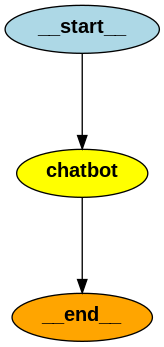

In [37]:
try:
    display(Image(graph.get_graph().draw_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

> Raises a weird error that should be fixed later too...

In [43]:
# try:
#     display(Image(graph.get_graph().draw_mermaid()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

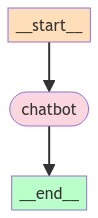

In [44]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

> Adopt either style you prefer or try several depending on circumstances.

## Run the Chatbot

In [48]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ("quit", "exit", "q"):
        rprint("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            rprint("Assistant: ", value["messages"][-1].content)

Assistant:  LangGraph is a language learning platform that uses AI technology to help users improve their language 
skills through interactive lessons, personalized feedback, and real-time practice exercises. The platform offers 
courses in various languages, including English, Spanish, French, and German, and caters to learners of all levels,
from beginners to advanced speakers. LangGraph also provides users with progress tracking tools, study reminders, 
and a community forum where they can connect with other language learners.

Goodbye!

## Inspect the LangSmith Trace

At the provided link.

## Limits

You may have noticed that **the bot's knowledge is limited to what's in its training data**.

In the next part, **we will add a Web search tool to expand the bot's knowledge** and make it more capable.

['draw_ascii', 'draw_mermaid', 'draw_mermaid_png', 'draw_png']